In [1]:
import ngmix
import galsim
import fitsio
import numpy as np

import proplot as pplt

import matplotlib.pyplot as plt

In [2]:
d = fitsio.read("/Users/beckermr/Downloads/input_cosmos_v4.fits")

In [17]:
# do some cuts from https://github.com/des-science/y3-wl_image_sims/blob/master/end_to_end/config_files/e2e-008.yaml
# mag_i: [15., 25.]  #use only 15<mag_i<25.5 for now.
# isgal: [1,] #select galaxies only since we're simulating stars separately.
# mask_flags: [0,] #apply mask flags
# bdf_hlr: [0.,5.]

msk = (
    (d["mag_i"] >- 15)
    # & (d["mag_i"] <= 25.5)
    & (d["isgal"] == 1)
    & (d["mask_flags"] == 0)
    & (d["bdf_hlr"] >= 0)
    & (d["bdf_hlr"] <= 5)
)

d = d[msk]

In [18]:
dc = fitsio.read("/Users/beckermr/Downloads/COSMOS2020_FARMER_R1_v2.2_p3.fits", lower=True)

msk = (
    (dc["model_flag"] == 0)
    & (dc["flag_hsc"] == 0)
    & (dc["hsc_i_valid"])
    # & (dc["valid_source"])
)

dc = dc[msk]

In [19]:
dd = fitsio.read("/Users/beckermr/Downloads/run-gs-c06-mask.fits")

In [20]:
minds = np.searchsorted(dd["id"], d["des_id"])
dd = dd[minds]
assert np.array_equal(dd["id"], d["des_id"])

In [21]:
import smatch

matcher = smatch.Matcher(dd["ra"], dd["dec"])

In [22]:
idx, ind_d, ind_dc, rad = matcher.query_knn(dc["alpha_j2000"], dc["delta_j2000"], k=1, distance_upper_bound=0.263/3600.0, return_indices=True)

In [23]:
ind_d.shape, ind_dc.shape, rad.shape, idx.shape

((122750,), (122750,), (875112,), (875112,))

In [24]:
d = d[ind_d]
dd = dd[ind_d]
dc = dc[ind_dc]

In [25]:
from ngmix.prepsfmom import PGaussMom

PMOM = PGaussMom(2.0, pad_factor=8)

def get_bdf_gap(hlr, fracdev, flux, g1, g2, pixel_scale=0.05):
    """

    items:
        - type: Exponential
          half_light_radius: { type: catalog_sampler_value, col: bdf_hlr }
          ellip:
              type: GBeta
              g: { type: Eval, str: "np.sqrt(g1**2 + g2**2)", fg1: { type: catalog_sampler_value, col: bdf_g1 }, fg2: { type: catalog_sampler_value, col: bdf_g2 } }
              beta: { type: Random }
          flux: { type: Eval, str: "1-fracdev", ffracdev: { type: catalog_sampler_value, col: bdf_fracdev } }

        - type: DeVaucouleurs
          half_light_radius: '@gal.items.0.half_light_radius'
          ellip: "@gal.items.0.ellip"
          flux: "$1-@gal.items.0.flux"


    """
    _exp = (1.0 - fracdev) * galsim.Exponential(half_light_radius=hlr).shear(g1=g1, g2=g2)
    _dev = fracdev * galsim.DeVaucouleurs(half_light_radius=hlr).shear(g1=g1, g2=g2)
    gal = flux * (_exp + _dev)
    
    if False:
        gal_img = gal.drawImage(scale=pixel_scale, method="sb").array
        fgauss = galsim.Gaussian(
            fwhm=2.0
        )
        filter_img = galsim.Gaussian(
            fwhm=2.0
        ).drawImage(
            nx=gal_img.shape[1], 
            ny=gal_img.shape[0], 
            method="sb",
            scale=pixel_scale
        ).array
    
        gap_flux = np.sum(gal_img * filter_img) / fgauss.max_sb * pixel_scale**2

    if True:
        # this bit of code double check the ngmix pgauss flux is the same 
        # as the galsim flux above
        # worked fine!

        psf = galsim.Gaussian(fwhm=0.9)
        dx, dy = (np.random.uniform(size=2)-0.5) * 0.263
        gal_img = galsim.Convolve([gal.shift(dx, dy), psf]).drawImage(scale=0.263).array

        dx, dy = (np.random.uniform(size=2)-0.5) * 0.263
        psf_img = psf.shift(dx, dy).drawImage(nx=33, ny=33, scale=0.263).array
        psf_obs = ngmix.Observation(
            image=psf_img,
            weight=np.ones_like(psf_img),
            jacobian=ngmix.DiagonalJacobian(
                scale=0.263,
                row=16 + dy,
                col=16 + dx,
            )
        )
        
        cen = (gal_img.shape[0] - 1)/2.0
        obs = ngmix.Observation(
            image=gal_img,
            weight=np.ones_like(gal_img),
            jacobian=ngmix.DiagonalJacobian(
                scale=0.263,
                row=cen,
                col=cen,
            ),
            psf=psf_obs,
        )
        res = PMOM.go(obs)
        pgauss_flux = res["flux"]
        
        # print(pgauss_flux, gap_flux)

    return pgauss_flux  # gap_flux

In [26]:
ind = 231

gap_flux = get_bdf_gap(
    d["bdf_hlr"][ind], 
    d["bdf_fracdev"][ind],
    d["flux_i"][ind],
    d["bdf_g1"][ind],
    d["bdf_g2"][ind],
    pixel_scale=0.025,
)

In [27]:
import joblib

def _nan():
    return np.nan

jobs = [
    joblib.delayed(get_bdf_gap)(
        d["bdf_hlr"][ind], 
        d["bdf_fracdev"][ind],
        d["flux_i"][ind],
        d["bdf_g1"][ind],
        d["bdf_g2"][ind],
        pixel_scale=0.1,
    ) if np.random.uniform() < 0.05 else joblib.delayed(_nan)()
    for ind in range(len(d))
    
]

with joblib.Parallel(backend="loky", verbose=1, n_jobs=7) as par:
    gap_flux = np.array(par(jobs))

gap_mag = 30.0 - 2.5 * np.log10(gap_flux)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  76 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 13042 tasks      | elapsed:    4.5s
[Parallel(n_jobs=7)]: Done 45042 tasks      | elapsed:   17.7s
[Parallel(n_jobs=7)]: Done 83612 tasks      | elapsed:   39.2s
[Parallel(n_jobs=7)]: Done 120308 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 122750 out of 122750 | elapsed:  1.7min finished


In [28]:
magi = dc["hsc_i_mag"]

bin_edges = np.linspace(17, 25, 25)
bmag = []
dmag = []
for i in range(len(bin_edges)-1):
    msk = (
        (magi >= bin_edges[i])
        & (magi <= bin_edges[i+1])
    )
    bmag.append(np.nanmedian(magi[msk]))
    dmag.append(np.nanmedian(gap_mag[msk]) - bmag[-1])

Text(0, 0.5, 'pgauss - hsc_i_mag (bigger is fainter)')

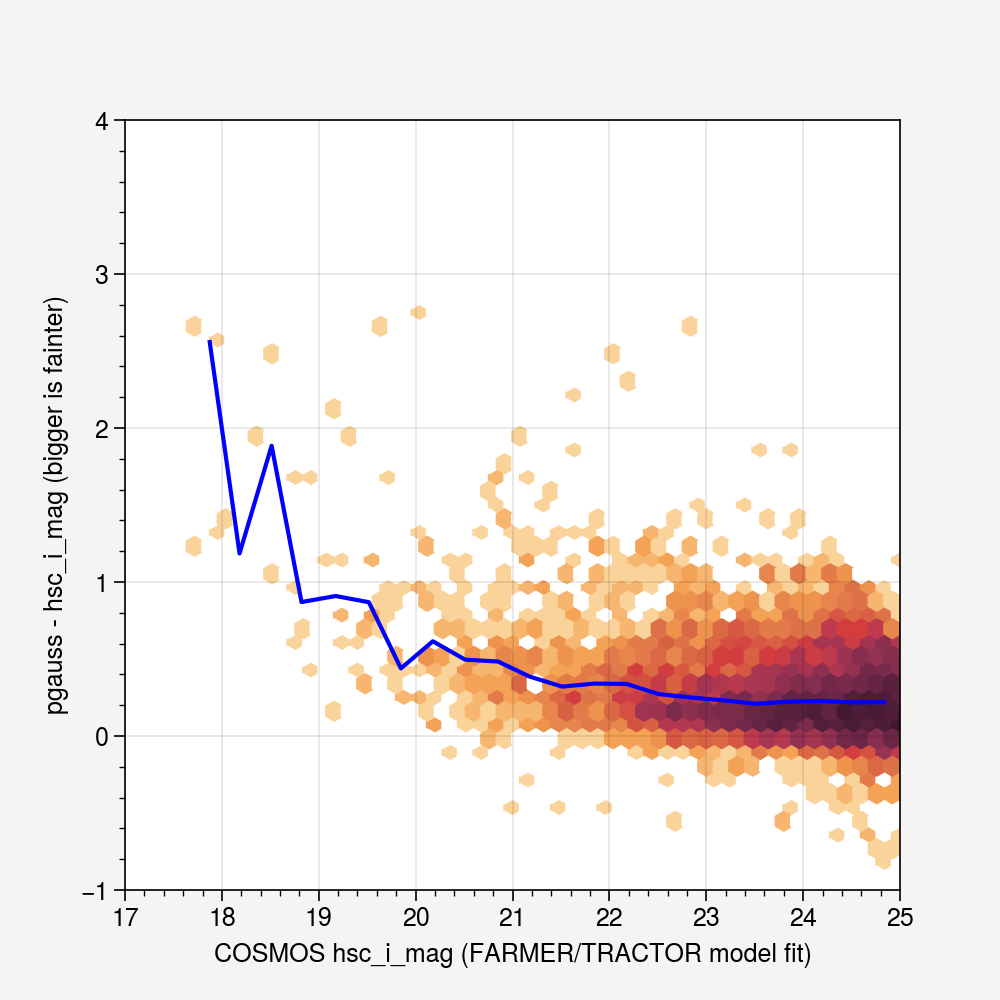

In [29]:
fig, axs = plt.subplots(figsize=(5, 5))

axs.hexbin(
    magi, 
    gap_mag-magi, 
    gridsize=50,
    bins="log",
    extent=[17, 25, -1, 4],
)
axs.plot(bmag, dmag, "-", color="blue")
axs.set_xlim(17, 25)
axs.set_ylim(-1, 4)
axs.set_xlabel("COSMOS hsc_i_mag (FARMER/TRACTOR model fit)")
axs.set_ylabel("pgauss - hsc_i_mag (bigger is fainter)")

In [30]:
print("The new cut is:", np.round(
    np.interp(24.5, bmag, dmag) + 24.5,
    2,
))

The new cut is: 24.72
